In [153]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import tensorflow as tf

In [3]:
pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.


Import the data and create categorical data categories for the prices of cards

In [154]:
creatures = pd.read_csv('creatures_cleaned.csv', index_col=[0])
noncreatures = pd.read_csv('noncreatures_cleaned.csv',index_col=[0])

In [155]:
creatures = creatures.reset_index(drop=True)
creatures

,name,mana_cost,cmc,oracle_text,power,toughness,prices,set,rarity
0,Storm Crow,{1}{U},2.0,Flying (This creature can't be blocked except ...,1.0,2.0,0.20,9ed,0
1,Walking Sponge,{1}{U},2.0,{T}: Target creature loses your choice of flyi...,1.0,1.0,0.15,ulg,1
2,Pteramander,{U},1.0,Flying {7}{U}: Adapt 4. This ability costs {1}...,1.0,1.0,0.15,rna,1
3,Nantuko Elder,{2}{G},3.0,{T}: Add {C}{G}.,1.0,2.0,0.56,ody,1
4,Vedalken Heretic,{G}{U},2.0,Whenever This Card deals damage to an opponent...,1.0,1.0,0.26,arb,2
...,...,...,...,...,...,...,...,...,...
12152,Borderland Ranger,{2}{G},3.0,When This Card enters the battlefield you may...,2.0,2.0,0.05,avr,0
12153,Quarry Beetle,{4}{G},5.0,When This Card enters the battlefield you may...,4.0,5.0,0.06,hou,1
12154,Devoted Hero,{W},1.0,_,1.0,2.0,0.18,s99,0
12155,Firesong and Sunspeaker,{4}{R}{W},6.0,Red instant and sorcery spells you control hav...,4.0,6.0,0.30,2x2,2


In [157]:
for index, row in creatures.iterrows():
    prices = row['prices']
    bucket = 0
    if prices <= 5:
        bucket = 0
    elif prices <= 10:
        bucket =1
    elif prices <=20:
        bucket = 2
    elif prices <= 50:
        bucket = 3
    else:
        bucket = 4
    creatures.loc[index, 'price_bucket'] = bucket
creatures

,name,mana_cost,cmc,oracle_text,power,toughness,prices,set,rarity,price_bucket
0,Storm Crow,{1}{U},2.0,Flying (This creature can't be blocked except ...,1.0,2.0,0.20,9ed,0,0.0
1,Walking Sponge,{1}{U},2.0,{T}: Target creature loses your choice of flyi...,1.0,1.0,0.15,ulg,1,0.0
2,Pteramander,{U},1.0,Flying {7}{U}: Adapt 4. This ability costs {1}...,1.0,1.0,0.15,rna,1,0.0
3,Nantuko Elder,{2}{G},3.0,{T}: Add {C}{G}.,1.0,2.0,0.56,ody,1,0.0
4,Vedalken Heretic,{G}{U},2.0,Whenever This Card deals damage to an opponent...,1.0,1.0,0.26,arb,2,0.0
...,...,...,...,...,...,...,...,...,...,...
12152,Borderland Ranger,{2}{G},3.0,When This Card enters the battlefield you may...,2.0,2.0,0.05,avr,0,0.0
12153,Quarry Beetle,{4}{G},5.0,When This Card enters the battlefield you may...,4.0,5.0,0.06,hou,1,0.0
12154,Devoted Hero,{W},1.0,_,1.0,2.0,0.18,s99,0,0.0
12155,Firesong and Sunspeaker,{4}{R}{W},6.0,Red instant and sorcery spells you control hav...,4.0,6.0,0.30,2x2,2,0.0


In [159]:
creatures['price_bucket'].value_counts()

0.0    11633
1.0      259
2.0      162
3.0       69
4.0       34
Name: price_bucket, dtype: int64

In [448]:
creatures.loc[creatures['price_bucket']>2]

,name,mana_cost,cmc,oracle_text,power,toughness,prices,set,rarity,price_bucket,compiled_text
259,"Seizan, Perverter of Truth",{3}{B}{B},5,At the beginning of each player's upkeep that...,6,5,34.38,chk,2,3,The mana cost of this card is {3}{B}{B}. The c...
444,Forest Bear,{1}{G},2,_,2,2,29.52,ptk,0,3,The mana cost of this card is {1}{G}. The conv...
516,Maralen of the Mornsong,{1}{B}{B},3,Players can't draw cards. At the beginning of ...,2,3,25.29,mor,2,3,The mana cost of this card is {1}{B}{B}. The c...
518,"Zhou Yu, Chief Commander",{5}{U}{U},7,This Card can't attack unless defending player...,8,8,112.95,ptk,2,4,The mana cost of this card is {5}{U}{U}. The c...
553,"Ulamog, the Ceaseless Hunger",{10},10,When you cast this spell exile two target per...,10,10,58.36,bfz,3,4,The mana cost of this card is {10}. The conver...
...,...,...,...,...,...,...,...,...,...,...,...
11716,Zodiac Horse,{3}{G},4,Islandwalk (This creature can't be blocked as ...,3,3,43.61,ptk,1,3,The mana cost of this card is {3}{G}. The conv...
11796,Terror of the Peaks,{3}{R}{R},5,Flying Spells your opponents cast that target ...,5,4,31.94,m21,3,3,The mana cost of this card is {3}{R}{R}. The c...
11929,Gosta Dirk,{3}{W}{W}{U}{U},7,First strike Creatures with islandwalk can be ...,4,4,48.04,leg,2,3,The mana cost of this card is {3}{W}{W}{U}{U}....
11956,Fury,{3}{R}{R},5,Double strike When This Card enters the battle...,3,3,21.13,mh2,3,3,The mana cost of this card is {3}{R}{R}. The c...


Creation of text vectorizer for text analysis

In [160]:
c_values = creatures['price_bucket'].values

In [6]:
stop_word = ['This Card']
oracle = creatures['oracle_text'].values
c_tfidfvectorizer = TfidfVectorizer(analyzer='word' , stop_words=stop_word)
c_tfidfvectorizer.fit(oracle)
c_tfidf_train = c_tfidfvectorizer.transform(oracle)
c_tfidf_term_vectors  = c_tfidfvectorizer.transform(oracle)
feature_names = c_tfidfvectorizer.get_feature_names()

C:\Users\rcrch\anaconda3\envs\PythonData\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['card', 'this'] not in stop_words.
  warnings.warn(
C:\Users\rcrch\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
test = pd.DataFrame(c_tfidf_train.T.todense(), index=feature_names)
test

,0,1,2,3,4,5,6,7,8,9,...,12147,12148,12149,12150,12151,12152,12153,12154,12155,12156
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zombie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zombies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
new_df = pd.DataFrame(c_tfidf_train.T.todense())
new_df = new_df.swapaxes("index", "columns")
new_df
combined_df = creatures
test_df = pd.concat([combined_df, new_df], axis=1)
test_df

,name,mana_cost,cmc,oracle_text,power,toughness,prices,set,rarity,price_bucket,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Storm Crow,{1}{U},2,Flying (This creature can't be blocked except ...,1,2,0.20,9ed,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Walking Sponge,{1}{U},2,{T}: Target creature loses your choice of flyi...,1,1,0.15,ulg,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Pteramander,{U},1,Flying {7}{U}: Adapt 4. This ability costs {1}...,1,1,0.15,rna,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Nantuko Elder,{2}{G},3,{T}: Add {C}{G}.,1,2,0.56,ody,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Vedalken Heretic,{G}{U},2,Whenever This Card deals damage to an opponent...,1,1,0.26,arb,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12152,Borderland Ranger,{2}{G},3,When This Card enters the battlefield you may...,2,2,0.05,avr,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12153,Quarry Beetle,{4}{G},5,When This Card enters the battlefield you may...,4,5,0.06,hou,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12154,Devoted Hero,{W},1,_,1,2,0.18,s99,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12155,Firesong and Sunspeaker,{4}{R}{W},6,Red instant and sorcery spells you control hav...,4,6,0.30,2x2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
new = test_df.drop(['set', 'name', 'oracle_text', 'mana_cost', 'compiled_text'], axis=1)
new

,cmc,power,toughness,prices,rarity,price_bucket,0,1,2,3,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,2,1,2,0.20,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,1,0.15,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,0.15,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,2,0.56,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1,1,0.26,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12152,3,2,2,0.05,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12153,5,4,5,0.06,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12154,1,1,2,0.18,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12155,6,4,6,0.30,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [231]:
new = new.drop(['prices'], axis=1)
new = new.astype('int64')
new

,cmc,power,toughness,rarity,price_bucket,0,1,2,3,4,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12152,3,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12153,5,4,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12154,1,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12155,6,4,6,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
new = new[['price_bucket', 'rarity', 'power', 'toughness', 'cmc']]
new

,price_bucket,rarity,power,toughness,cmc
0,0,0,1,2,2
1,0,1,1,1,2
2,0,1,1,1,1
3,0,1,1,2,3
4,0,2,1,1,2
...,...,...,...,...,...
12152,0,0,2,2,3
12153,0,1,4,5,5
12154,0,0,1,2,1
12155,0,2,4,6,6


In [161]:
for index, row in creatures.iterrows():
    mana_cost = row['mana_cost']
    cmc = row['cmc']
    power = row['power']
    toughness = row['toughness']
    rarity = row['rarity']
    completed_string = f"The mana cost of this card is {mana_cost}. The converted mana cost of this card is {cmc}. The power of this creature is {power}. The toughness of this card is {toughness}. The rarity of this card is {rarity}. The oracle text is as follows: {row['oracle_text']}."
    creatures.loc[index, 'compiled_text'] = completed_string
creatures

,name,mana_cost,cmc,oracle_text,power,toughness,prices,set,rarity,price_bucket,compiled_text
0,Storm Crow,{1}{U},2.0,Flying (This creature can't be blocked except ...,1.0,2.0,0.20,9ed,0,0.0,The mana cost of this card is {1}{U}. The conv...
1,Walking Sponge,{1}{U},2.0,{T}: Target creature loses your choice of flyi...,1.0,1.0,0.15,ulg,1,0.0,The mana cost of this card is {1}{U}. The conv...
2,Pteramander,{U},1.0,Flying {7}{U}: Adapt 4. This ability costs {1}...,1.0,1.0,0.15,rna,1,0.0,The mana cost of this card is {U}. The convert...
3,Nantuko Elder,{2}{G},3.0,{T}: Add {C}{G}.,1.0,2.0,0.56,ody,1,0.0,The mana cost of this card is {2}{G}. The conv...
4,Vedalken Heretic,{G}{U},2.0,Whenever This Card deals damage to an opponent...,1.0,1.0,0.26,arb,2,0.0,The mana cost of this card is {G}{U}. The conv...
...,...,...,...,...,...,...,...,...,...,...,...
12152,Borderland Ranger,{2}{G},3.0,When This Card enters the battlefield you may...,2.0,2.0,0.05,avr,0,0.0,The mana cost of this card is {2}{G}. The conv...
12153,Quarry Beetle,{4}{G},5.0,When This Card enters the battlefield you may...,4.0,5.0,0.06,hou,1,0.0,The mana cost of this card is {4}{G}. The conv...
12154,Devoted Hero,{W},1.0,_,1.0,2.0,0.18,s99,0,0.0,The mana cost of this card is {W}. The convert...
12155,Firesong and Sunspeaker,{4}{R}{W},6.0,Red instant and sorcery spells you control hav...,4.0,6.0,0.30,2x2,2,0.0,The mana cost of this card is {4}{R}{W}. The c...


In [164]:
creatures = creatures.astype({'price_bucket': 'int64', 'power': 'int64', 'toughness': 'int64', 'cmc':'int64'})

In [604]:
creatures.dtypes

name              object
mana_cost         object
cmc                int64
oracle_text       object
power              int64
toughness          int64
prices           float64
set               object
rarity             int64
price_bucket       int64
compiled_text     object
dtype: object

Split the Data

In [185]:
X = creatures['compiled_text'].values
y = creatures['price_bucket'].values
v = CountVectorizer()

In [87]:
val = creatures[['oracle_text', 'cmc', 'rarity', 'power', 'toughness', 'prices']]
val = val.astype({'cmc':'int64','rarity':'int64', 'power':'int64','toughness':'int64', 'prices':'int64'})
val_x = val.drop(['prices'], axis=1)
val_y = val[['prices']]

In [88]:
X_combined = val_x.values
y_combined = val_y.values
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, random_state=42)

In [89]:
begin = []
end = []
for x in X_train:
    text = x[0]
    begin.append(text)
for y in X_test:
    text = y[0]
    end.append(text)
new_begin = v.fit_transform(begin).toarray()
new_end = v.transform(end).toarray()
i=0
for x in X_train:
    x[0] = new_begin[i]
    i+=1
i=0
for y in X_test:
    y[0] = new_end[i]
    i+=1

In [368]:
new

,price_bucket,rarity,power,toughness,cmc
0,0,0,1,2,2
1,0,1,1,1,2
2,0,1,1,1,1
3,0,1,1,2,3
4,0,2,1,1,2
...,...,...,...,...,...
12152,0,0,2,2,3
12153,0,1,4,5,5
12154,0,0,1,2,1
12155,0,2,4,6,6


In [204]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

9117
3040
9117
3040


In [375]:
y = new['price_bucket'].values
X = new.drop(['price_bucket'],axis=1).values
v = CountVectorizer()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Test the vectorized text data to 31% accuracy

In [217]:
X_test_count = v.transform(X_test)
X_test_count = X_test_count.toarray()
# model.score(X_test_count, y_test)

0.31776315789473686

In [603]:
print(len(X_test_count))
print(len(X_train_count))

3040
9117


Using the split data without text fit to creatures with a GaussianNB

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [379]:
gmodel = GaussianNB()

In [380]:
gmodel.fit(X_train,y_train)

GaussianNB()

In [381]:
gmodel.score(X_test, y_test)

0.930921052631579

In [399]:
predictions = gmodel.predict(bX)

In [607]:
jpreds = gmodel.predict(jX)

In [407]:
from sklearn.metrics import confusion_matrix

In [419]:
confusion_matrix(by, predictions)

array([[169,   0,  17,   0],
       [  2,   0,   2,   0],
       [  2,   0,   2,   0],
       [  5,   0,   0,   0]], dtype=int64)

In [608]:
confusion_matrix(jy, jpreds)

array([[281,   0,  19,   0],
       [ 13,   0,   1,   0],
       [  9,   0,   2,   0],
       [  3,   0,   0,   0]], dtype=int64)

In [609]:
jy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [610]:
jpreds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [219]:
model.fit(X_train_count,y_train)

GaussianNB()

In [220]:
model.score(X_test_count, y_test)

0.31776315789473686

In [215]:
X_test_count = v.transform(X_test)
X_test_count = X_test_count.toarray()
model.score(X_test_count, y_test)

0.31776315789473686

Create further testing data to match the conditions of the previous models

In [394]:
bc_df = pd.read_csv('c2.csv', index_col=[0])
bc_df = bc_df.reset_index(drop=True)

In [395]:
bc_df

,name,mana_cost,cmc,oracle_text,power,toughness,prices,set,rarity
0,Simian Simulacrum,{3},3.0,When This Card enters the battlefield put two...,2.0,1.0,0.29,bro,2
1,Sardian Cliffstomper,{1}{R},2.0,As long as it's your turn and you control four...,0.0,4.0,2.68,bro,1
2,"Liberator, Urza's Battlethopter",{3},3.0,Flash Flying You may cast colorless spells and...,1.0,2.0,3.77,bro,2
3,Skystrike Officer,{2}{U},3.0,Flying Whenever This Card attacks create a 1/...,2.0,3.0,0.79,bro,2
4,Bladecoil Serpent,{X}{6},6.0,When This Card enters the battlefield for eac...,5.0,4.0,1.57,bro,3
...,...,...,...,...,...,...,...,...,...
194,"Gix, Yawgmoth Praetor",{1}{B}{B},3.0,Whenever a creature deals combat damage to one...,3.0,3.0,22.27,bro,3
195,Clay Revenant,{1},1.0,This Card enters the battlefield tapped. {2}{B...,1.0,2.0,0.03,bro,0
196,Thraxodemon,{1}{B},2.0,{3} {T} Sacrifice another creature or artifa...,2.0,2.0,0.05,bro,0
197,"Mishra, Tamer of Mak Fawa",{3}{B}{R},5.0,"Permanents you control have ""Ward—Sacrifice a ...",4.0,4.0,0.84,bro,2


In [396]:
for index, row in bc_df.iterrows():
    price = row['prices']
    bucket = 0
    if price <=5:
        bucket =0
    elif price <=10:
        bucket= 1
    elif price <=20:
        bucket = 2
    elif price <= 50:
        bucket =3
    else:
        bucket =4
    bc_df.loc[index, 'price_bucket'] = bucket
bc_df

,name,mana_cost,cmc,oracle_text,power,toughness,prices,set,rarity,price_bucket
0,Simian Simulacrum,{3},3.0,When This Card enters the battlefield put two...,2.0,1.0,0.29,bro,2,0.0
1,Sardian Cliffstomper,{1}{R},2.0,As long as it's your turn and you control four...,0.0,4.0,2.68,bro,1,0.0
2,"Liberator, Urza's Battlethopter",{3},3.0,Flash Flying You may cast colorless spells and...,1.0,2.0,3.77,bro,2,0.0
3,Skystrike Officer,{2}{U},3.0,Flying Whenever This Card attacks create a 1/...,2.0,3.0,0.79,bro,2,0.0
4,Bladecoil Serpent,{X}{6},6.0,When This Card enters the battlefield for eac...,5.0,4.0,1.57,bro,3,0.0
...,...,...,...,...,...,...,...,...,...,...
194,"Gix, Yawgmoth Praetor",{1}{B}{B},3.0,Whenever a creature deals combat damage to one...,3.0,3.0,22.27,bro,3,3.0
195,Clay Revenant,{1},1.0,This Card enters the battlefield tapped. {2}{B...,1.0,2.0,0.03,bro,0,0.0
196,Thraxodemon,{1}{B},2.0,{3} {T} Sacrifice another creature or artifa...,2.0,2.0,0.05,bro,0,0.0
197,"Mishra, Tamer of Mak Fawa",{3}{B}{R},5.0,"Permanents you control have ""Ward—Sacrifice a ...",4.0,4.0,0.84,bro,2,0.0


In [397]:
bc_df = bc_df.astype({'cmc': 'int64', 'power':'int64', 'toughness':'int64', 'price_bucket': 'int64'})
bc2 = bc_df[['cmc', 'power', 'toughness', 'rarity', 'price_bucket']]
bc2

,cmc,power,toughness,rarity,price_bucket
0,3,2,1,2,0
1,2,0,4,1,0
2,3,1,2,2,0
3,3,2,3,2,0
4,6,5,4,3,0
...,...,...,...,...,...
194,3,3,3,3,3
195,1,1,2,0,0
196,2,2,2,0,0
197,5,4,4,2,0


In [398]:
by = bc2['price_bucket'].values
bX = bc2.drop(['price_bucket'], axis=1).values

A seperate validation dataset

In [429]:
jc_df = pd.read_csv('c3.csv', index_col=[0])
jc_df = jc_df.reset_index(drop=True)
for index, row in jc_df.iterrows():
    price = row['prices']
    bucket = 0
    if price <=5:
        bucket =0
    elif price <=10:
        bucket= 1
    elif price <=20:
        bucket = 2
    elif price <= 50:
        bucket =3
    else:
        bucket =4
    jc_df.loc[index, 'price_bucket'] = bucket
jc_df = jc_df.astype({'cmc': 'int64', 'power':'int64', 'toughness':'int64', 'price_bucket': 'int64'})
jc2 = jc_df[['cmc', 'power', 'toughness', 'rarity', 'price_bucket']]
jy = jc2['price_bucket'].values
jX = jc2.drop(['price_bucket'], axis=1).values

In [421]:
jX

array([[ 3,  2,  1,  2],
       [ 2,  0,  4,  1],
       [ 3,  1,  2,  2],
       [ 3,  2,  3,  2],
       [ 6,  5,  4,  3],
       [ 5,  2,  5,  1],
       [ 2,  3,  2,  3],
       [ 3,  4,  3,  1],
       [ 5,  4,  6,  3],
       [ 1,  1,  1,  0],
       [ 3,  4,  4,  0],
       [ 5,  4,  5,  1],
       [ 6,  5,  4,  2],
       [ 3,  2,  3,  0],
       [ 2,  1,  1,  1],
       [ 5,  3,  5,  2],
       [ 5,  3,  3,  2],
       [ 1,  1,  1,  2],
       [ 5,  5,  5,  3],
       [ 4,  4,  3,  2],
       [ 6,  5,  5,  1],
       [ 2,  2,  1,  0],
       [ 2,  2,  2,  0],
       [ 3,  3,  3,  3],
       [ 4,  4,  3,  2],
       [ 1,  1,  1,  1],
       [ 4,  2,  3,  0],
       [ 7,  5,  3,  2],
       [ 9,  9,  9,  0],
       [ 8,  8,  8,  3],
       [10,  8,  8,  2],
       [ 7,  7,  5,  3],
       [ 5,  4,  4,  1],
       [ 5,  3,  4,  0],
       [ 9,  4,  4,  3],
       [ 9,  7,  7,  1],
       [ 3,  2,  4,  2],
       [ 3,  2,  2,  0],
       [ 3,  1,  3,  1],
       [ 5,  3,  5,  2],


In [430]:
jpreds = gmodel.predict(jX)
jpreds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [423]:
jy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0], dtype=int64)

In [431]:
confusion_matrix(jy, jpreds)

array([[281,   0,  19,   0],
       [ 13,   0,   1,   0],
       [  9,   0,   2,   0],
       [  3,   0,   0,   0]], dtype=int64)

Begin Deep Learning Analysis of this information

In [137]:
test = creatures[['cmc', 'power', 'toughness', 'rarity', 'prices']]

In [138]:
y = test['prices'].values
X = test.drop(['prices'], axis=1).values

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [348]:
scaler = StandardScaler()

In [349]:
X_scaler = scaler.fit(X_train)

In [350]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [242]:
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  20
hidden_nodes_layer2 = 15
hidden_nodes_layer3 = 10
nn = tf.keras.models.Sequential()

In [243]:
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="sigmoid")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='tanh'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                100       
                                                                 
 dense_5 (Dense)             (None, 15)                315       
                                                                 
 dense_6 (Dense)             (None, 10)                160       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 586
Trainable params: 586
Non-trainable params: 0
_________________________________________________________________


In [244]:
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [245]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
285/285 [==============================] - 1s 1ms/step - loss: 0.2842 - accuracy: 0.9503
Epoch 2/100
285/285 [==============================] - 0s 1ms/step - loss: 0.2189 - accuracy: 0.9547
Epoch 3/100
285/285 [==============================] - 0s 854us/step - loss: 0.1971 - accuracy: 0.9449
Epoch 4/100
285/285 [==============================] - 0s 884us/step - loss: 0.1937 - accuracy: 0.9395
Epoch 5/100
285/285 [==============================] - 0s 882us/step - loss: 0.1906 - accuracy: 0.9379
Epoch 6/100
285/285 [==============================] - 0s 867us/step - loss: 0.1886 - accuracy: 0.9395
Epoch 7/100
285/285 [==============================] - 0s 848us/step - loss: 0.1875 - accuracy: 0.9412
Epoch 8/100
285/285 [==============================] - 0s 849us/step - loss: 0.1857 - accuracy: 0.9393
Epoch 9/100
285/285 [==============================] - 0s 912us/step - loss: 0.1851 - accuracy: 0.9401
Epoch 10/100
285/285 [==============================] - 0s 837us/step - loss:

In [246]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh', 'sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=50,
        step=5), activation=activation, input_dim=4))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=50,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [247]:
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=50,
    hyperband_iterations=2,
    overwrite=True)

In [248]:
tuner.search(X_train_scaled,y_train,epochs=50,validation_data=(X_test_scaled,y_test))

Trial 180 Complete [00h 00m 19s]
val_accuracy: 0.9575657844543457

Best val_accuracy So Far: 0.9582237005233765
Total elapsed time: 00h 13m 34s
INFO:tensorflow:Oracle triggered exit


In [249]:
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'relu', 'first_units': 31, 'num_layers': 5, 'units_0': 46, 'units_1': 41, 'units_2': 26, 'units_3': 26, 'units_4': 16, 'tuner/epochs': 6, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 21, 'num_layers': 5, 'units_0': 11, 'units_1': 41, 'units_2': 16, 'units_3': 41, 'units_4': 26, 'tuner/epochs': 6, 'tuner/initial_epoch': 2, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': '0094'}
{'activation': 'relu', 'first_units': 41, 'num_layers': 3, 'units_0': 46, 'units_1': 26, 'units_2': 16, 'units_3': 21, 'units_4': 36, 'tuner/epochs': 6, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [250]:
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

95/95 - 0s - loss: 0.1976 - accuracy: 0.9582 - 263ms/epoch - 3ms/step
Loss: 0.1975952684879303, Accuracy: 0.9582237005233765
95/95 - 0s - loss: 0.1948 - accuracy: 0.9582 - 265ms/epoch - 3ms/step
Loss: 0.1948285549879074, Accuracy: 0.9582237005233765
95/95 - 0s - loss: 0.1989 - accuracy: 0.9579 - 220ms/epoch - 2ms/step
Loss: 0.19894710183143616, Accuracy: 0.9578947424888611


In [253]:
first_hyper = tuner.get_best_hyperparameters(2)[0]
first_hyper.values

{'activation': 'relu',
 'first_units': 31,
 'num_layers': 5,
 'units_0': 46,
 'units_1': 41,
 'units_2': 26,
 'units_3': 26,
 'units_4': 16,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [255]:
second_hyper = tuner.get_best_hyperparameters(2)[1]
second_hyper.values

{'activation': 'relu',
 'first_units': 21,
 'num_layers': 5,
 'units_0': 11,
 'units_1': 41,
 'units_2': 16,
 'units_3': 41,
 'units_4': 26,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 3,
 'tuner/round': 1,
 'tuner/trial_id': '0094'}

In [277]:
model = tuner.hypermodel.build(first_hyper)

In [278]:
model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
228/228 [==============================] - 1s 2ms/step - loss: 0.2857 - accuracy: 0.9442 - val_loss: 0.2051 - val_accuracy: 0.9600
Epoch 2/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1969 - accuracy: 0.9558 - val_loss: 0.2013 - val_accuracy: 0.9600
Epoch 3/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1901 - accuracy: 0.9548 - val_loss: 0.1994 - val_accuracy: 0.9452
Epoch 4/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1880 - accuracy: 0.9482 - val_loss: 0.2087 - val_accuracy: 0.9446
Epoch 5/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1833 - accuracy: 0.9489 - val_loss: 0.1966 - val_accuracy: 0.9424
Epoch 6/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 0.9425 - val_loss: 0.1933 - val_accuracy: 0.9424
Epoch 7/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9467 - val_loss: 0.1942 - val_accuracy: 0.9529

Epoch 58/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1714 - accuracy: 0.9483 - val_loss: 0.1925 - val_accuracy: 0.9539
Epoch 59/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1721 - accuracy: 0.9505 - val_loss: 0.1919 - val_accuracy: 0.9490
Epoch 60/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1706 - accuracy: 0.9491 - val_loss: 0.1868 - val_accuracy: 0.9512
Epoch 61/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1720 - accuracy: 0.9480 - val_loss: 0.1916 - val_accuracy: 0.9507
Epoch 62/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1707 - accuracy: 0.9484 - val_loss: 0.1972 - val_accuracy: 0.9529
Epoch 63/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1702 - accuracy: 0.9501 - val_loss: 0.1868 - val_accuracy: 0.9463
Epoch 64/100
228/228 [==============================] - 0s 1ms/step - loss: 0.1703 - accuracy: 0.9453 - val_loss: 0.1924 - val_accuracy:

In [279]:
model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

95/95 - 0s - loss: -2.2959e-02 - accuracy: 0.9382 - 76ms/epoch - 799us/step
Loss: -0.022958623245358467, Accuracy: 0.9381579160690308


In [280]:
second_model = tuner.hypermodel.build(second_hyper)

In [281]:
second_model.fit(X_train_scaled, y_train, epochs=275, validation_split=0.2)

Epoch 1/275
228/228 [==============================] - 1s 2ms/step - loss: 0.2780 - accuracy: 0.9548 - val_loss: 0.2024 - val_accuracy: 0.9600
Epoch 2/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1924 - accuracy: 0.9554 - val_loss: 0.1932 - val_accuracy: 0.9600
Epoch 3/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1854 - accuracy: 0.9531 - val_loss: 0.1943 - val_accuracy: 0.9496
Epoch 4/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1829 - accuracy: 0.9447 - val_loss: 0.1899 - val_accuracy: 0.9485
Epoch 5/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1796 - accuracy: 0.9450 - val_loss: 0.1921 - val_accuracy: 0.9331
Epoch 6/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1823 - accuracy: 0.9424 - val_loss: 0.1934 - val_accuracy: 0.9589
Epoch 7/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1767 - accuracy: 0.9450 - val_loss: 0.1985 - val_accuracy: 0.9583

Epoch 58/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 0.9427 - val_loss: 0.1909 - val_accuracy: 0.9539
Epoch 59/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1765 - accuracy: 0.9457 - val_loss: 0.1852 - val_accuracy: 0.9397
Epoch 60/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1774 - accuracy: 0.9420 - val_loss: 0.1850 - val_accuracy: 0.9375
Epoch 61/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1758 - accuracy: 0.9431 - val_loss: 0.1826 - val_accuracy: 0.9452
Epoch 62/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 0.9439 - val_loss: 0.1879 - val_accuracy: 0.9359
Epoch 63/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1788 - accuracy: 0.9434 - val_loss: 0.1830 - val_accuracy: 0.9435
Epoch 64/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1760 - accuracy: 0.9453 - val_loss: 0.1854 - val_accuracy:

Epoch 115/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1627 - accuracy: 0.9449 - val_loss: 0.1844 - val_accuracy: 0.9457
Epoch 116/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1639 - accuracy: 0.9453 - val_loss: 0.1852 - val_accuracy: 0.9446
Epoch 117/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1622 - accuracy: 0.9475 - val_loss: 0.1844 - val_accuracy: 0.9518
Epoch 118/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1643 - accuracy: 0.9452 - val_loss: 0.1835 - val_accuracy: 0.9463
Epoch 119/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1616 - accuracy: 0.9475 - val_loss: 0.1821 - val_accuracy: 0.9441
Epoch 120/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1603 - accuracy: 0.9450 - val_loss: 0.1968 - val_accuracy: 0.9567
Epoch 121/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1642 - accuracy: 0.9461 - val_loss: 0.1818 - val_ac

228/228 [==============================] - 0s 1ms/step - loss: 0.1470 - accuracy: 0.9427 - val_loss: 0.1938 - val_accuracy: 0.9463
Epoch 228/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1476 - accuracy: 0.9445 - val_loss: 0.1929 - val_accuracy: 0.9485
Epoch 229/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1476 - accuracy: 0.9468 - val_loss: 0.1904 - val_accuracy: 0.9435
Epoch 230/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1467 - accuracy: 0.9491 - val_loss: 0.1889 - val_accuracy: 0.9353
Epoch 231/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1468 - accuracy: 0.9452 - val_loss: 0.1881 - val_accuracy: 0.9457
Epoch 232/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1462 - accuracy: 0.9452 - val_loss: 0.1903 - val_accuracy: 0.9523
Epoch 233/275
228/228 [==============================] - 0s 1ms/step - loss: 0.1464 - accuracy: 0.9479 - val_loss: 0.1925 - val_accuracy: 0.9468

In [284]:
second_model_loss, second_model_accuracy = second_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {second_model_loss}, Accuracy: {second_model_accuracy}")

95/95 - 0s - loss: 0.2202 - accuracy: 0.9322 - 74ms/epoch - 782us/step
Loss: 0.22017398476600647, Accuracy: 0.9322368502616882


In [340]:
scaler = StandardScaler()

In [352]:
bX_scaler = scaler.transform(bX)

In [342]:
bX_train_scaled = X_scaler.transform(bX_train)
# bX_test_scaled = X_scaler.transform(bX_test)

In [353]:
b_model_loss, b_model_accuracy = model.evaluate(bX,by,verbose=2)
print(f"Loss: {b_model_loss}, Accuracy: {b_model_accuracy}")

5/5 - 0s - loss: 0.9677 - accuracy: 0.7105 - 119ms/epoch - 24ms/step
Loss: 0.9677452445030212, Accuracy: 0.7105262875556946


In [354]:
b2_model_loss, b2_model_accuracy = second_model.evaluate(bX,by,verbose=2)
print(f"Loss: {b2_model_loss}, Accuracy: {b2_model_accuracy}")

5/5 - 0s - loss: 1.7740 - accuracy: 0.5855 - 119ms/epoch - 24ms/step
Loss: 1.7740129232406616, Accuracy: 0.5855262875556946


In [443]:
probability_model = tf.keras.Sequential([second_model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(bX)

7/7 [==============================] - 0s 1ms/step


In [444]:
predictions

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [358]:
first = model.predict(bX)
second = second_model.predict(bX)

5/5 [==============================] - 0s 1ms/step


In [402]:
names = bc_df['name'].values

In [434]:
first

array([[5.49834013e-01],
       [7.13570714e-01],
       [1.25429395e-03],
       [3.09188992e-01],
       [5.81292622e-03],
       [5.40683806e-01],
       [1.01654297e-02],
       [3.75512153e-01],
       [1.55916461e-03],
       [3.43727879e-02],
       [8.53990838e-02],
       [5.49834013e-01],
       [1.22512713e-01],
       [7.39994228e-01],
       [5.71905093e-06],
       [8.34963992e-02],
       [5.81292622e-03],
       [6.54259278e-03],
       [9.92733752e-04],
       [3.96475982e-04],
       [7.12704122e-01],
       [2.32753227e-03],
       [4.55834985e-01],
       [3.55367422e-01],
       [5.49834013e-01],
       [9.74119842e-01],
       [5.88809016e-05],
       [4.12485242e-01],
       [5.15575148e-02],
       [3.72433305e-01],
       [2.13943142e-03],
       [8.90690982e-02],
       [4.29250598e-02],
       [7.70915508e-01],
       [1.18775688e-01],
       [9.99999881e-01],
       [2.08136048e-02],
       [2.71485168e-02],
       [1.39372572e-02],
       [2.34944820e-02],


In [360]:
len(first)

152

In [366]:
prices1 = {}
prices2 = {}
i=0
for name in names:
    prices1[name] = first[i][0]
    prices2[name] = second[i][0]
    i+=1

In [367]:
prices1

{'Thraxodemon': 0.549834,
 'Phyrexian Dragon Engine': 0.7135707,
 'Goring Warplow': 0.001254294,
 'Carrion Locust': 0.309189,
 'Power Plant Worker': 0.005812926,
 'Arbalest Engineers': 0.5406838,
 'Koilos Roc': 0.01016543,
 'Gixian Skullflayer': 0.37551215,
 'Combat Thresher': 0.0015591646,
 'Lat-Nam Adept': 0.034372788,
 'Yotian Tactician': 0.085399084,
 'Argothian Sprite': 0.549834,
 'Roc Hunter': 0.12251271,
 'Queen Kayla bin-Kroog': 0.7399942,
 'Woodcaller Automaton': 5.719051e-06,
 'Scrapwork Cohort': 0.0834964,
 "Tocasia's Onulet": 0.005812926,
 'Aeronaut Cavalry': 0.006542593,
 'Gnarlroot Pallbearer': 0.0009927338,
 'Blitz Automaton': 0.00039647598,
 'Sardian Cliffstomper': 0.7127041,
 'Cradle Clearcutter': 0.0023275323,
 'Gurgling Anointer': 0.45583498,
 'Gixian Infiltrator': 0.35536742,
 'Phalanx Vanguard': 0.549834,
 'Mishra, Claimed by Gix': 0.97411984,
 'Su-Chi Cave Guard': 5.88809e-05,
 'Battlefield Butcher': 0.41248524,
 'Retrieval Agent': 0.051557515,
 'Tower Worker': 0.

In [447]:
prices1.values()

dict_values([0.549834, 0.7135707, 0.001254294, 0.309189, 0.005812926, 0.5406838, 0.01016543, 0.37551215, 0.0015591646, 0.034372788, 0.085399084, 0.549834, 0.12251271, 0.7399942, 5.719051e-06, 0.0834964, 0.005812926, 0.006542593, 0.0009927338, 0.00039647598, 0.7127041, 0.0023275323, 0.45583498, 0.35536742, 0.549834, 0.97411984, 5.88809e-05, 0.41248524, 0.051557515, 0.3724333, 0.0021394314, 0.0890691, 0.04292506, 0.7709155, 0.11877569, 0.9999999, 0.020813605, 0.027148517, 0.013937257, 0.023494482, 0.31376547, 0.010196289, 1.0, 0.5843125, 0.02026994, 0.11877569, 0.7135707, 0.35536742, 0.40506256, 0.85089725, 0.04637028, 0.054776367, 0.9999999, 0.35536742, 0.35536742, 0.007016777, 0.7259577, 0.012225804, 0.04292506, 0.37551215, 1.1381267e-06, 1.0, 0.07794352, 0.54068416, 0.04292506, 0.18705681, 0.2763712, 0.19316253, 0.11877569, 0.82286435, 0.9999999, 0.7397269, 0.9686126, 0.5397552, 0.00874431, 0.67171407, 0.07103178, 0.45521843, 0.7399942, 0.15234901, 0.0073973117, 0.76675534, 0.00019406

Begin a Unsupervised attempt to understand this phenomenon

In [449]:
clf = RandomForestClassifier()

In [453]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [454]:
clf.score(X_test, y_test)

0.9542763157894737

In [456]:
bforest_predictions = clf.predict(bX)

In [457]:
confusion_matrix(by, bforest_predictions)

array([[164,   9,  13,   0],
       [  4,   0,   0,   0],
       [  2,   2,   0,   0],
       [  5,   0,   0,   0]], dtype=int64)

In [611]:
jforest_predictions = clf.predict(jX)

In [612]:
confusion_matrix(jy, jforest_predictions)

array([[278,  16,   6,   0],
       [ 14,   0,   0,   0],
       [ 11,   0,   0,   0],
       [  3,   0,   0,   0]], dtype=int64)

KMeans examination

In [471]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [463]:
new

,price_bucket,rarity,power,toughness,cmc
0,0,0,1,2,2
1,0,1,1,1,2
2,0,1,1,1,1
3,0,1,1,2,3
4,0,2,1,1,2
...,...,...,...,...,...
12152,0,0,2,2,3
12153,0,1,4,5,5
12154,0,0,1,2,1
12155,0,2,4,6,6


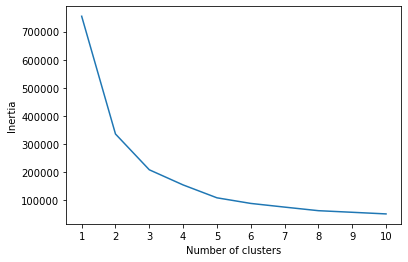

In [525]:
inertia = []
# Same as k = list(range(1, 11))
k = [1,2,3,4,5,6,7,8,9,10]


# Looking for the best k
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(newer)
    inertia.append(km.inertia_)

# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [466]:
kmodel = KMeans(n_clusters=3, random_state=5)

In [467]:
kmodel.fit(new)

KMeans(n_clusters=3, random_state=5)

In [469]:
kpreds = kmodel.predict(new)

In [472]:
trial = new[['rarity', 'power', 'toughness', 'cmc']]
trial

,rarity,power,toughness,cmc
0,0,1,2,2
1,1,1,1,2
2,1,1,1,1
3,1,1,2,3
4,2,1,1,2
...,...,...,...,...
12152,0,2,2,3
12153,1,4,5,5
12154,0,1,2,1
12155,2,4,6,6


In [519]:
pca = PCA(n_components=2)

In [520]:
new_pca = pca.fit_transform(trial)

In [521]:
pca.explained_variance_ratio_

array([0.7248567 , 0.10747603])

In [522]:
newer = pd.DataFrame(new_pca)
newer

,0,1
0,-2.435927,0.491721
1,-2.858363,-0.229374
2,-3.442968,0.536459
3,-1.709573,-0.444829
4,-2.716614,-0.400091
...,...,...
12152,-1.285777,0.011267
12153,2.848823,0.530774
12154,-3.020532,1.257553
12155,4.139360,0.144601


In [523]:
newer['prices'] = creatures['prices']
newer

,0,1,prices
0,-2.435927,0.491721,0.20
1,-2.858363,-0.229374,0.15
2,-3.442968,0.536459,0.15
3,-1.709573,-0.444829,0.56
4,-2.716614,-0.400091,0.26
...,...,...,...
12152,-1.285777,0.011267,0.05
12153,2.848823,0.530774,0.06
12154,-3.020532,1.257553,0.18
12155,4.139360,0.144601,0.30


In [524]:
newer = newer.rename(columns = {0:'pca1', 1:'pca2'})
newer

,pca1,pca2,prices
0,-2.435927,0.491721,0.20
1,-2.858363,-0.229374,0.15
2,-3.442968,0.536459,0.15
3,-1.709573,-0.444829,0.56
4,-2.716614,-0.400091,0.26
...,...,...,...
12152,-1.285777,0.011267,0.05
12153,2.848823,0.530774,0.06
12154,-3.020532,1.257553,0.18
12155,4.139360,0.144601,0.30


In [526]:
kmodel = KMeans(n_clusters=5, random_state=5)

In [527]:
kmodel.fit(newer)

KMeans(n_clusters=5, random_state=5)

In [528]:
kpreds = kmodel.predict(newer)

In [529]:
newer['labels'] = kmodel.labels_
newer

,pca1,pca2,prices,labels
0,-2.435927,0.491721,0.20,0
1,-2.858363,-0.229374,0.15,0
2,-3.442968,0.536459,0.15,0
3,-1.709573,-0.444829,0.56,0
4,-2.716614,-0.400091,0.26,0
...,...,...,...,...
12152,-1.285777,0.011267,0.05,0
12153,2.848823,0.530774,0.06,4
12154,-3.020532,1.257553,0.18,0
12155,4.139360,0.144601,0.30,4


In [497]:
newer['name'] = creatures['name']
newer

,pca,price_bucket,labels,name
0,-2.435927,0,0,Storm Crow
1,-2.858363,0,0,Walking Sponge
2,-3.442968,0,0,Pteramander
3,-1.709573,0,0,Nantuko Elder
4,-2.716614,0,0,Vedalken Heretic
...,...,...,...,...
12152,-1.285777,0,0,Borderland Ranger
12153,2.848823,0,2,Quarry Beetle
12154,-3.020532,0,0,Devoted Hero
12155,4.139360,0,1,Firesong and Sunspeaker


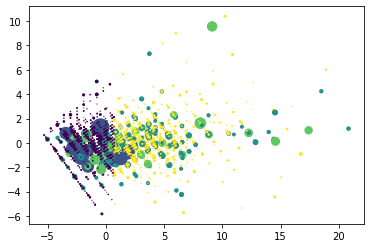

In [531]:
plt.scatter(newer['pca1'],newer['pca2'], newer['prices'], c=kmodel.labels_)

TSNE analysis of same information

In [532]:
from sklearn.manifold import TSNE

In [533]:
new

,price_bucket,rarity,power,toughness,cmc,label
0,0,0,1,2,2,1
1,0,1,1,1,2,1
2,0,1,1,1,1,1
3,0,1,1,2,3,1
4,0,2,1,1,2,1
...,...,...,...,...,...,...
12152,0,0,2,2,3,1
12153,0,1,4,5,5,0
12154,0,0,1,2,1,1
12155,0,2,4,6,6,2


In [534]:
tsdf = new.drop(['price_bucket'], axis=1)
labels = new['price_bucket']

In [535]:
tsne = TSNE(learning_rate=35)

In [537]:
tsne_features = tsne.fit_transform(tsdf)

C:\Users\rcrch\anaconda3\envs\PythonData\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [538]:
tsne_features.shape

(12157, 2)

In [539]:
tsdf['x'] = tsne_features[:,0]
tsdf['y'] = tsne_features[:,1]

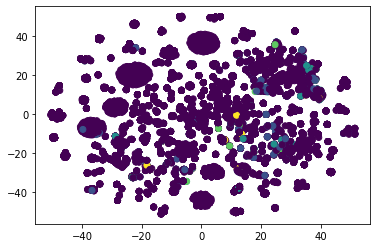

In [544]:
plt.scatter(tsdf['x'], tsdf['y'], c=labels)
plt.show()

In [543]:
labels.value_counts()

0    11633
1      259
2      162
3       69
4       34
Name: price_bucket, dtype: int64

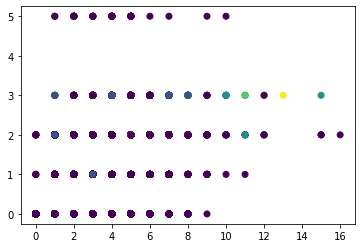

In [546]:
plt.scatter(new['cmc'], new['rarity'], c=labels)

Attempted textual understanding of system using a deep learning tensorflow model

In [547]:
stop_word = ['This Card']
oracle = creatures['oracle_text'].values
c_tfidfvectorizer = TfidfVectorizer(analyzer='word' , stop_words=stop_word)
c_tfidfvectorizer.fit(oracle)
c_tfidf_train = c_tfidfvectorizer.transform(oracle)
c_tfidf_term_vectors  = c_tfidfvectorizer.transform(oracle)
feature_names = c_tfidfvectorizer.get_feature_names()
test = pd.DataFrame(c_tfidf_train.T.todense(), index=feature_names)
new_df = pd.DataFrame(c_tfidf_train.T.todense())
new_df = new_df.swapaxes("index", "columns")
combined_df = creatures
test_df = pd.concat([combined_df, new_df], axis=1)
trial = test_df.drop(['set', 'name', 'oracle_text', 'mana_cost', 'compiled_text'], axis=1)
trial

C:\Users\rcrch\anaconda3\envs\PythonData\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['card', 'this'] not in stop_words.
  warnings.warn(
C:\Users\rcrch\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,cmc,power,toughness,prices,rarity,price_bucket,0,1,2,3,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,2,1,2,0.20,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,1,0.15,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,0.15,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,2,0.56,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1,1,0.26,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12152,3,2,2,0.05,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12153,5,4,5,0.06,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12154,1,1,2,0.18,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12155,6,4,6,0.30,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [549]:
trial = trial.drop(['price_bucket'],axis=1)

In [550]:
vy = trial['prices']
vX = trial.drop(['prices'],axis=1)

In [551]:
vX_train, vX_test, vy_train, vy_test = train_test_split(vX, vy, random_state=42)

In [552]:
scaler = StandardScaler()
vX_train_scaled = scaler.fit_transform(vX_train) 

C:\Users\rcrch\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\rcrch\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [553]:
vX_test_scaled = scaler.transform(vX_test)

C:\Users\rcrch\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [555]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh', 'sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=50,
        step=5), activation=activation, input_dim=2018))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=50,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [557]:
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=50,
    hyperband_iterations=2,
    overwrite=True)

In [558]:
tuner.search(vX_train_scaled,vy_train,epochs=50,validation_data=(vX_test_scaled,vy_test))

Trial 180 Complete [00h 00m 38s]
val_accuracy: 0.0006578947650268674

Best val_accuracy So Far: 0.0006578947650268674
Total elapsed time: 00h 23m 26s
INFO:tensorflow:Oracle triggered exit


Begin Examining noncreature spells

In [559]:
noncreatures

,name,mana_cost,cmc,oracle_text,prices,set,rarity
0,Static Orb,{3},3.0,As long as This Card is untapped players can'...,20.58,7ed,2
1,Sensory Deprivation,{U},1.0,Enchant creature Enchanted creature gets -3/-0.,0.04,m14,0
2,Road of Return,{G}{G},2.0,Choose one — • Return target permanent card fr...,0.24,c19,2
3,Ravnica at War,{3}{W},4.0,Exile all multicolored permanents.,0.23,war,2
4,Torrent of Fire,{3}{R}{R},5.0,This Card deals damage to any target equal to ...,0.12,scg,0
...,...,...,...,...,...,...,...
10454,Curse of Thirst,{4}{B},5.0,Enchant player At the beginning of enchanted p...,0.30,dka,1
10455,Temporary Truce,{1}{W},2.0,Each player may draw up to two cards. For each...,11.45,por,2
10456,Clearwater Goblet,{5},5.0,Sunburst (This enters the battlefield with a c...,0.44,5dn,2
10457,Without Weakness,{1}{B},2.0,Target creature you control gains indestructib...,0.04,hou,0


In [560]:
nc_df = noncreatures[['cmc','prices','rarity']]
nc_df

,cmc,prices,rarity
0,3.0,20.58,2
1,1.0,0.04,0
2,2.0,0.24,2
3,4.0,0.23,2
4,5.0,0.12,0
...,...,...,...
10454,5.0,0.30,1
10455,2.0,11.45,2
10456,5.0,0.44,2
10457,2.0,0.04,0


In [561]:
for index, row in nc_df.iterrows():
    price = row['prices']
    bucket = 0
    if price <= 5:
        bucket = 0
    elif price <= 10:
        bucket = 1
    elif price <=20:
        bucket=2
    elif price <=50:
        bucket =3
    else:
        bucket =4
    nc_df.loc[index, 'price_bucket'] = bucket
nc_df

C:\Users\rcrch\AppData\Local\Temp\ipykernel_30284\4250240917.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nc_df.loc[index, 'price_bucket'] = bucket


,cmc,prices,rarity,price_bucket
0,3.0,20.58,2,3.0
1,1.0,0.04,0,0.0
2,2.0,0.24,2,0.0
3,4.0,0.23,2,0.0
4,5.0,0.12,0,0.0
...,...,...,...,...
10454,5.0,0.30,1,0.0
10455,2.0,11.45,2,2.0
10456,5.0,0.44,2,0.0
10457,2.0,0.04,0,0.0


In [562]:
nc_df = nc_df.astype({'cmc':'int64','price_bucket':'int64'})
nc_df.dtypes

cmc               int64
prices          float64
rarity            int64
price_bucket      int64
dtype: object

In [563]:
y = nc_df['price_bucket'].values
X = nc_df.drop(['prices', 'price_bucket'],axis=1)

In [564]:
nX_train, nX_test, ny_train, ny_test = train_test_split(X,y, random_state=42)

In [578]:
bn_df = pd.read_csv('brothers_noncreatures.csv',index_col=[0]).reset_index(drop=True)

In [579]:
for index, row in bn_df.iterrows():
    price = row['prices']
    bucket = 0
    if price <= 5:
        bucket = 0
    elif price <= 10:
        bucket =1
    elif price <= 20:
        bucket=2
    elif price <= 50:
        bucket=3
    else:
        bucket =4 
    bn_df.loc[index, 'price_bucket'] = bucket
bn_df

,name,mana_cost,cmc,oracle_text,prices,set,rarity,price_buckets,price_bucket
0,Gix's Caress,{2}{B},3.0,Target opponent reveals their hand. You choose...,0.12,bro,0,0,0.0
1,Thran Vigil,{1}{B},2.0,Whenever one or more artifact and/or creature ...,0.13,bro,1,0,0.0
2,Diabolic Intent,{1}{B},2.0,As an additional cost to cast this spell sacr...,6.90,bro,2,1,1.0
3,One with the Multiverse,{6}{U}{U},8.0,You may look at the top card of your library a...,3.26,bro,3,0,0.0
4,Fog of War,{2}{G},3.0,You gain 1 life for each creature on the battl...,0.11,bro,0,0,0.0
...,...,...,...,...,...,...,...,...,...
120,Urza's Command,{2}{U}{U},4.0,Choose two — • Creatures you don't control get...,0.30,bro,2,0,0.0
121,Urza's Sylex,{3},3.0,{2}{W}{W} {T} Exile This Card: Each player c...,2.21,bro,3,0,0.0
122,Hall of Tagsin,_,0.0,{T}: Add {C}. {1} {T}: Add one mana of any co...,0.19,bro,2,0,0.0
123,Energy Refractor,{2},2.0,When This Card enters the battlefield draw a ...,0.18,bro,0,0,0.0


In [580]:
bn_df = bn_df.astype({'cmc':'int64','price_bucket':'int64'})

In [581]:
bny = bn_df['price_bucket'].values
bnX = bn_df[['cmc', 'rarity']].values

In [566]:
ngmodel = GaussianNB()

In [567]:
ngmodel.fit(nX_train, ny_train)

GaussianNB()

In [568]:
ngmodel.score(nX_test, ny_test)

0.9179566563467493

In [582]:
ngpred = ngmodel.predict(bnX)

C:\Users\rcrch\anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [583]:
confusion_matrix(bny, ngpred)

array([[121,   0,   0,   0],
       [  1,   0,   0,   0],
       [  2,   0,   0,   0],
       [  0,   1,   0,   0]], dtype=int64)

In [569]:
nforest = RandomForestClassifier()

In [570]:
nforest.fit(nX_test, ny_test)

RandomForestClassifier()

In [571]:
nforest.score(nX_test, ny_test)

0.9206656346749226

In [585]:
nfpred = nforest.predict(bnX)

C:\Users\rcrch\anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [586]:
confusion_matrix(bny, nfpred)

array([[121,   0,   0,   0],
       [  1,   0,   0,   0],
       [  2,   0,   0,   0],
       [  1,   0,   0,   0]], dtype=int64)

In [588]:
expensive_creatures = creatures.loc[creatures['prices'] >=20]

In [589]:
expensive_noncreatures = noncreatures.loc[noncreatures['prices']>=20]

In [596]:
expensive_creatures['set'].value_counts()
26+7+3+2

ptk    26
leg     7
2xm     6
mh2     5
2x2     4
mh1     4
usg     3
uds     2
cn2     2
10e     2
arn     2
clb     2
bbd     2
mir     2
emn     2
uma     2
ima     2
jmp     2
gnt     1
bfz     1
wth     1
ogw     1
afr     1
tmp     1
e01     1
shm     1
lgn     1
hou     1
pca     1
mor     1
cmr     1
ema     1
drk     1
dmu     1
scg     1
thb     1
khm     1
m19     1
ths     1
chk     1
inv     1
brc     1
a25     1
p02     1
m21     1
Name: set, dtype: int64

In [598]:
pd.options.display.max_rows = 4000
expensive_noncreatures['set'].value_counts()
15+10+7+5+4+4+4

leg     15
2xm     11
pvan    10
2x2      9
ptk      7
uma      5
usg      5
ktk      5
vis      4
c20      4
arn      4
atq      4
chk      4
zen      3
c14      3
tmp      3
uds      3
shm      3
2ed      3
cm2      3
mh1      3
jmp      2
war      2
m21      2
ody      2
dom      2
ima      2
cn2      2
cc1      2
tsr      2
drk      2
exo      2
m15      2
cmr      2
5dn      2
csp      2
sok      2
lrw      2
neo      2
wth      2
ons      2
ulg      2
ema      2
c13      1
mmq      1
c16      1
mrd      1
roe      1
c17      1
mir      1
wwk      1
por      1
m19      1
jou      1
bbd      1
c15      1
cmd      1
isd      1
frf      1
clb      1
eld      1
ths      1
rix      1
9ed      1
gvl      1
rna      1
oarc     1
dtk      1
mh2      1
iko      1
parc     1
s99      1
dmu      1
mid      1
eve      1
rav      1
mbs      1
8ed      1
akh      1
a25      1
plc      1
7ed      1
Name: set, dtype: int64

In [600]:
len(expensive_creatures)

104

In [601]:
len(expensive_noncreatures)

194

In [602]:
print(49/194)
print(39/104)

0.25257731958762886
0.375
